# About the Notebook:
This notebook uses the [RAVDESS](https://zenodo.org/record/1188976#.YEBgAWgzZEY) Dataset to train a gender detection model using Machine learning methodologies.

In [ ]:
#importing neccessary modules
import os
import glob
import pandas as pd
#modules for audio signal processing
import librosa
import librosa.display
# for hearing audio samples in the notebook
import IPython.display as disp
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import multiprocessing as mp
import concurrent.futures
NUMBER_OF_CPU_IN_POOL = 6
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import pickle

In [ ]:
#loading the dataset
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/GenderDetectionUsingVoice')

In [ ]:
#unzipping the dataset
#!unzip Dataset.zip
!ls

Actor_01  Actor_07  Actor_13  Actor_19	Dataset.zip	 svm_pitch.pkl
Actor_02  Actor_08  Actor_14  Actor_20	labels.npy	 svm_spectogram.pkl
Actor_03  Actor_09  Actor_15  Actor_21	mfcc.npy	 TestSamples
Actor_04  Actor_10  Actor_16  Actor_22	pitch.npy
Actor_05  Actor_11  Actor_17  Actor_23	spectograms.npy
Actor_06  Actor_12  Actor_18  Actor_24	svm_mfcc.pkl


#1. Dataset Exploration Stage.

File naming convention

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics: 

Filename identifiers 

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
#Dataset path
for actor_directory in glob.glob('Actor*'):
    for audio_file_name in glob.glob(actor_directory+"/*.wav"):
      print(audio_file_name)

Actor_14/03-02-01-01-01-01-14.wav
Actor_14/03-02-02-01-02-02-14.wav
Actor_14/03-02-01-01-01-02-14.wav
Actor_14/03-02-01-01-02-02-14.wav
Actor_14/03-02-02-01-01-01-14.wav
Actor_14/03-02-01-01-02-01-14.wav
Actor_14/03-02-02-02-02-01-14.wav
Actor_14/03-02-02-02-02-02-14.wav
Actor_14/03-02-02-01-02-01-14.wav
Actor_14/03-02-02-01-01-02-14.wav
Actor_14/03-02-02-02-01-02-14.wav
Actor_14/03-02-02-02-01-01-14.wav
Actor_14/03-02-03-02-01-02-14.wav
Actor_14/03-02-03-02-02-01-14.wav
Actor_14/03-02-03-02-02-02-14.wav
Actor_14/03-02-03-01-01-01-14.wav
Actor_14/03-02-04-01-02-01-14.wav
Actor_14/03-02-03-01-01-02-14.wav
Actor_14/03-02-03-02-01-01-14.wav
Actor_14/03-02-03-01-02-01-14.wav
Actor_14/03-02-04-01-01-01-14.wav
Actor_14/03-02-04-01-01-02-14.wav
Actor_14/03-02-03-01-02-02-14.wav
Actor_14/03-02-05-01-01-01-14.wav
Actor_14/03-02-05-01-02-02-14.wav
Actor_14/03-02-04-02-02-01-14.wav
Actor_14/03-02-05-01-01-02-14.wav
Actor_14/03-02-04-02-01-01-14.wav
Actor_14/03-02-04-01-02-02-14.wav
Actor_14/03-02

Clearly the *.wav files in each directory follows the file-naming convention as described above.

# 2-A. Data-Extraction Stage.
Since, we need only the labels(Male/Female) and the corresponding dataframes. We'll be storing them in a pandas dataframe


In [ ]:
#initialising the dataframe with columns
gender_dataset = pd.DataFrame(columns = ['path', 'gender'])
#now iterating and populating the dataframe.
index = 0
for actor_directory in glob.glob('Actor*'):
    for audio_file_name in glob.glob(actor_directory+"/*.wav"):
      #fetching the gender label as per the file-naming convention.
      actor = int(audio_file_name.split('.')[0].split('-')[-1])
      # if actor is odd then male else female
      if actor %2 ==0:
        gender = "female"
      else:
        gender = "male"
      #appending the values to dataframe 
      gender_dataset.loc[index] = [audio_file_name, gender]
      index+=1

In [ ]:
#shuffling the dataframe
gender_dataset = gender_dataset.sample(frac = 1)
#printing the length of dataset
print(len(gender_dataset)) 
#printing the dataframe's head
gender_dataset.head(20)

1012


,path,gender
849,Actor_10/03-02-03-01-02-02-10.wav,female
563,Actor_03/03-02-06-01-02-02-03.wav,male
940,Actor_12/03-02-03-01-02-02-12.wav,female
124,Actor_16/03-02-05-02-01-02-16.wav,female
653,Actor_05/03-02-06-02-01-01-05.wav,male
474,Actor_01/03-02-06-02-02-01-01.wav,male
981,Actor_13/03-02-03-01-02-01-13.wav,male
822,Actor_09/03-02-05-01-02-02-09.wav,male
422,Actor_24/03-02-04-02-01-01-24.wav,female
757,Actor_08/03-02-01-01-02-01-08.wav,female


In [ ]:
#let's hear few samples from the dataset
#change idx between 1, len(gender_dataset)
#male sample
idx = 56
disp.Audio(gender_dataset['path'][idx])

In [ ]:
# female sample
idx = 35
disp.Audio(gender_dataset['path'][idx])


# 2.B Distinguishable Feature Analysis. 
 
 **High-Level Features**
 Instrumentation, key, chords, melody, rhythm, tempo, lyrics.

 **Mid-Level Features**
Pitch, MFCCs etc

 **Low-Level Feature Extraction**
Amplitude, Energy, Spectral centroid, Zero Crossing Rate.

In this stage, we'll be extracting some of the aforementioned features from two samples of sounds(Male/Female Class) primarily in the following two domains.

1.   Time Domain features
2.   Time-Frequency Domain features.


---



We hope to shortlist relevant features and their domain which can be used for training ML model for the given task.

Let's start!

##### 1 . Time Domain Feature Extraction pipeline.


*   Amplitude analysis. 
*   RMS analysis.
*   Zero Crossing Analysis.





In [ ]:
##1. Amplitude Analysis
# sounds can be mono/stereo.
male_idx = 56
female_idx = 35
male_sound, sampling_rate1 = librosa.load(gender_dataset['path'][male_idx], mono=True)
female_sound, sampling_rate2 = librosa.load(gender_dataset['path'][female_idx], mono = True)

In [ ]:
# finding the number of samples in the male_sound and female_sound
print("Number of samples in the male_sound is {} and the sampling rate is {} hz".format(len(male_sound), sampling_rate1))
print("Number of samples in the female_sound is {} and the sampling rate is {} hz".format(len(female_sound), sampling_rate2))


Number of samples in the male_sound is 100796 and the sampling rate is 22050 hz
Number of samples in the female_sound is 81667 and the sampling rate is 22050 hz


## Observation
so, we can see that the sampling rates are 0.5* 44.1Khz and the number of samples in the male_sound and female_sound sampels are not uniform.

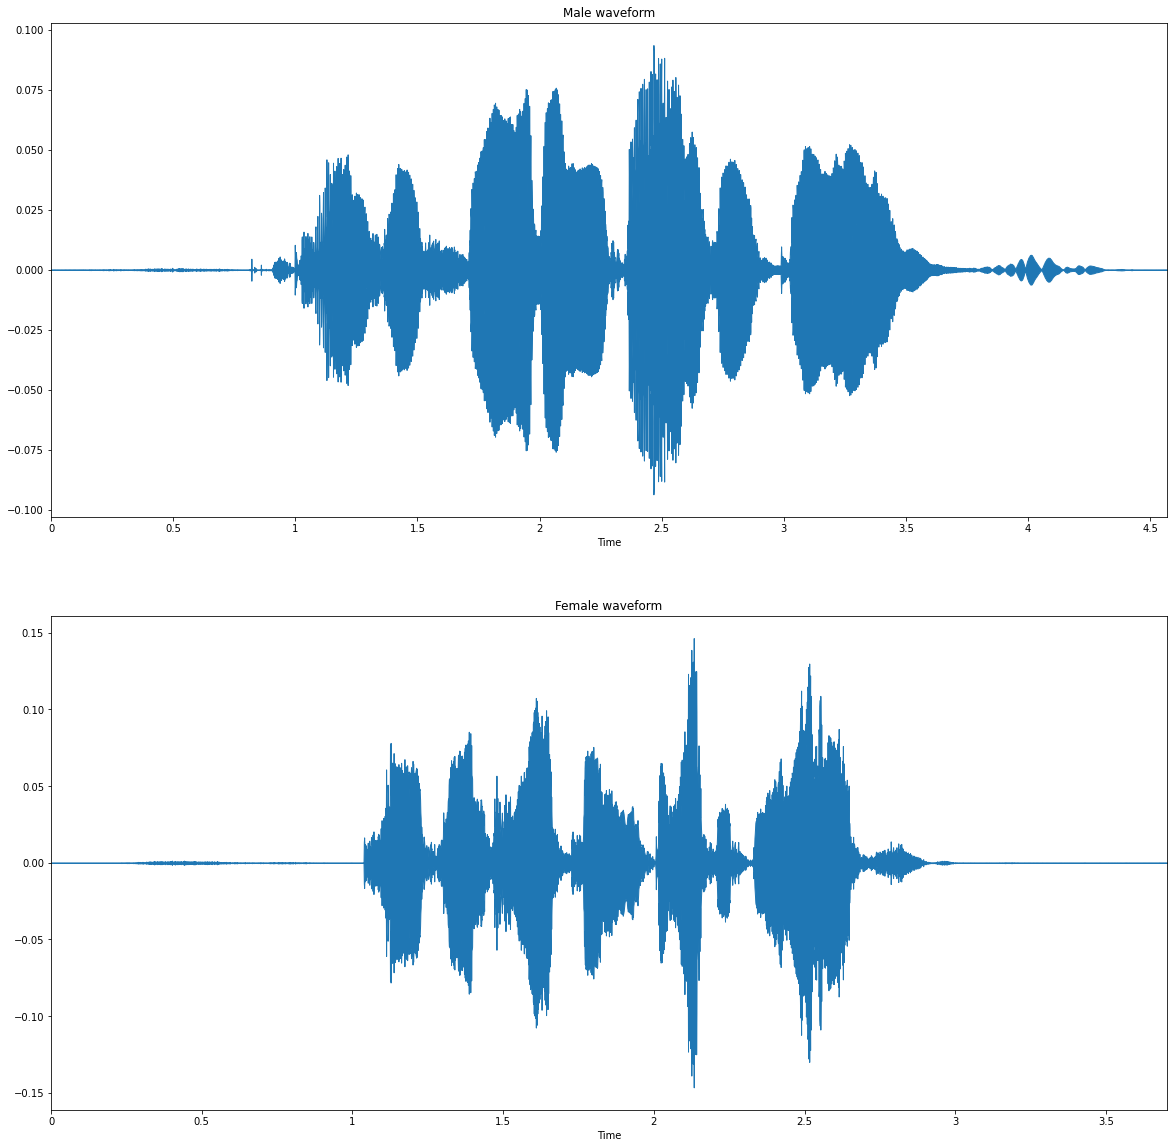

In [ ]:
#plotting the waveforms for male and female
plt.figure(figsize = (20,20))
plt.subplot(2,1,1)
plt.title("Male waveform")
librosa.display.waveplot(male_sound)
plt.subplot(2,1,2)
plt.title("Female waveform")
librosa.display.waveplot(female_sound)


In [ ]:
#defining the amplitude aggregator function
# we usually keep these in power of 2 to have faster Fourier transforms.
hop = 512
frame_size = 1024

def amplitude_aggregator(waveform, hop,frame_size):
  aggregator = []
  for i in range(0, len(waveform), hop):
    aggregator.append(max(waveform[i: i+hop]))
  
  return np.asarray(aggregator)


In [ ]:
#calculating amplitude for male and female
amp_male = amplitude_aggregator(male_sound,hop,frame_size)
amp_female = amplitude_aggregator(female_sound,hop,frame_size)
print(len(amp_male) == len(amp_female))

False


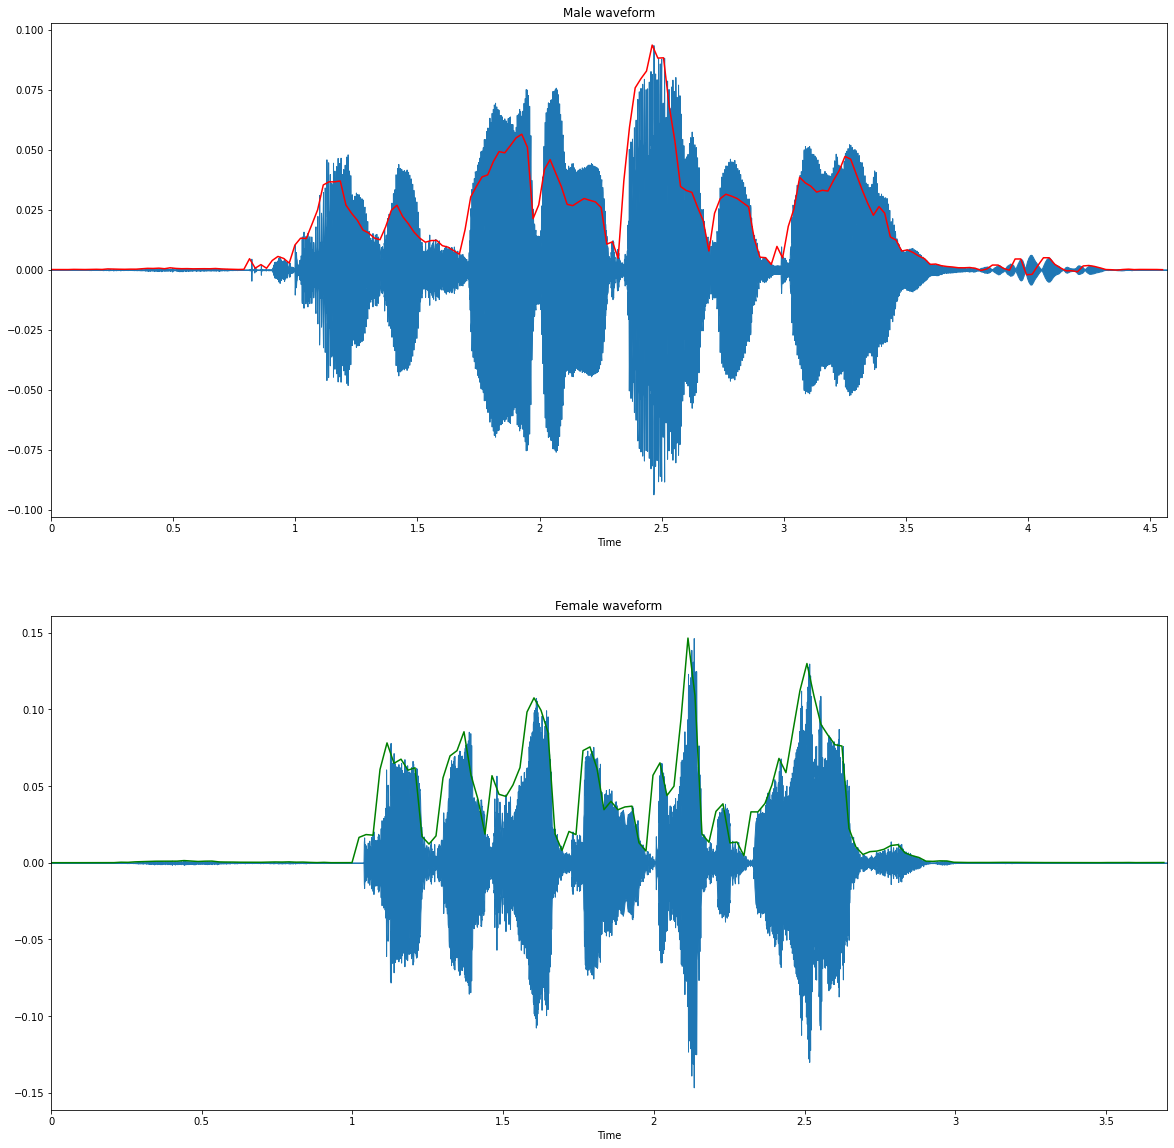

In [ ]:
# now plotting the max amplitude
frames_male = range(0, len(amp_male))
time_male = librosa.frames_to_time(frames_male, hop_length= hop)
frames_female= range(0, len(amp_female))
time_female = librosa.frames_to_time(frames_female, hop_length= hop)

plt.figure(figsize = (20,20))
plt.subplot(2,1,1)
plt.title("Male waveform")
librosa.display.waveplot(male_sound)
plt.plot(time_male, amp_male, color='r')
plt.subplot(2,1,2)
plt.title("Female waveform")
librosa.display.waveplot(female_sound)
plt.plot(time_female, amp_female, color='g')


# Observation
Clearly from the plots above, we can see that merely amplitude of waveform can't be used for classifying the input sound as male/female.

However, Amplitude analysis can be great for genre classifier tasks where we can assume genres like pop, indie etc will have a similar waveform. Similarly we can relate that Root Mean Square, Zero Crossing etc also won't be a deciding factor to classify the signal into our desired labels. So, we can conclude that time-domain features won't be worth for this task.

Let's explore Time-Frequency domain features.

# Pre-requisites for carrying frequency/time-frequency domain feature analysis of the waveforms


*   Knowledge of Fourier Transform.






In [ ]:
# let's analyse the man and woman's audio samples in the frequency domain
# Since a discrete fourier transform gives coefficients which can yield both phase and magnitude spectrum i.e a+bj , we are mostly interested in the mag spectrum here.
def plot_mag_spectrum(waveform, sample_type):
  #calculating the dft's coeeff
  fft_coeff = np.fft.fft(waveform)
  #calculating the magnitude spectrum
  mag = np.abs(fft_coeff)
  #creating freq_bins to plot
  #since sampling rate was 22.05 KHz 
  freq_bins = np.linspace(0,22050,len(mag))
  #now plotting
  plt.plot(freq_bins, mag)
  plt.xlabel('Frequency in Hz')
  plt.title(sample_type)
  plt.show()


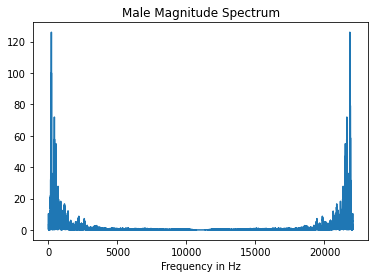

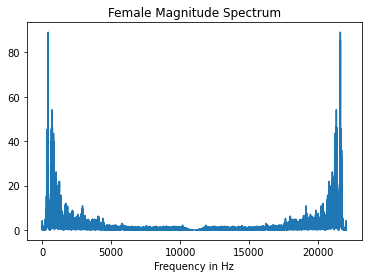

In [ ]:
#plot for male
plot_mag_spectrum(male_sound, "Male Magnitude Spectrum")
#plot for female
plot_mag_spectrum(female_sound, "Female Magnitude Spectrum")

# Observation
Clearly, We can't expect our model to differentiate between Male and female over magnitude spectrum too.

Hence, we'll be looking into extracting Spectograms. We'll need to extract STFT(Short time fourier transform) for this. Spectograms give us Freq-Time plot.

* Spectogram is squared magnitude of STFT

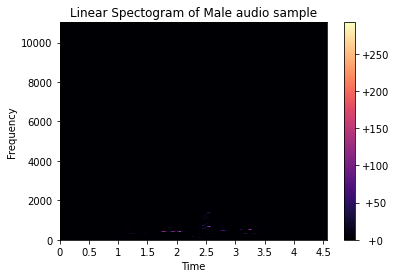

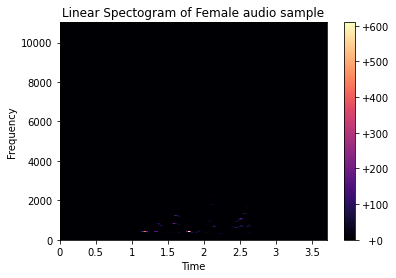

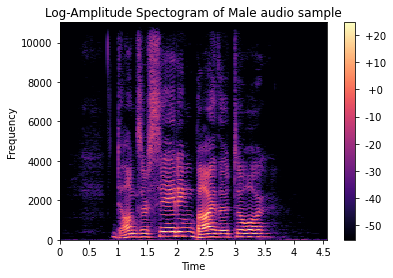

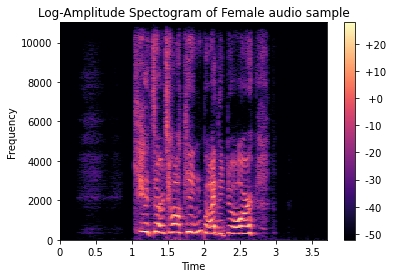

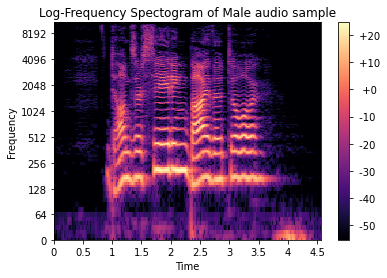

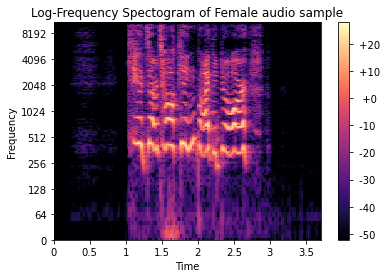

In [ ]:
#We will be primarily calculating two types of spectogram; Log frequency and Log amplitude besides the linear spectogram 

def calculate_spectogram(type,  waveform,frame_size, hop, label= None, return_output= False, visualize = True):
  if type == "linear":
    stft_standard = librosa.stft(waveform,n_fft= frame_size, hop_length= hop)
    freq = np.abs(stft_standard) **2
    librosa.display.specshow(freq, sr=22050, hop_length= hop, x_axis="time", y_axis = "linear")
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title(label)
    plt.colorbar(format="%+4.f")
    plt.show()
  
  elif type == "log-amplitude":
    stft_standard = librosa.stft(waveform,n_fft= frame_size, hop_length= hop)
    freq = np.abs(stft_standard) **2
    #converting frequency to log scale
    log_freq = librosa.power_to_db(freq)
    librosa.display.specshow(log_freq, sr=22050, hop_length= hop, x_axis="time", y_axis = "linear")
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title(label)
    plt.colorbar(format="%+4.f")
    plt.show()


  elif type == "log-frequency":
    stft_standard = librosa.stft(waveform,n_fft= frame_size, hop_length= hop)
    freq = np.abs(stft_standard) **2
    #converting frequency to log scale
    log_freq = librosa.power_to_db(freq)
    if return_output == True:
      return log_freq
    elif visualize == True:
      librosa.display.specshow(log_freq, sr=22050, hop_length= hop, x_axis="time", y_axis = "log")
      plt.ylabel('Frequency')
      plt.xlabel('Time')
      plt.title(label)
      plt.colorbar(format="%+4.f")
      plt.show()
    

frame_size = 2048
hop_size= 512

calculate_spectogram("linear",male_sound,frame_size,hop_size,"Linear Spectogram of Male audio sample")
calculate_spectogram("linear",female_sound,frame_size,hop_size,"Linear Spectogram of Female audio sample")
calculate_spectogram("log-amplitude",male_sound,frame_size,hop_size,"Log-Amplitude Spectogram of Male audio sample")
calculate_spectogram("log-amplitude",female_sound,frame_size,hop_size,"Log-Amplitude Spectogram of Female audio sample")
calculate_spectogram("log-frequency",male_sound,frame_size,hop_size,"Log-Frequency Spectogram of Male audio sample")
calculate_spectogram("log-frequency",female_sound,frame_size,hop_size,"Log-Frequency Spectogram of Female audio sample")

# Observation:
We can visually see some difference between Log-frequency spectograms of male and female audio samples. We can shortlist this feature for now.

Let's calculate mel spectogram and mel-frequency cepstral coefficients too for both signals and check if that can be used as a feature. 

Besides these, let's calculate the pitch of the sound as by literature we already know that women(165-255 Hz) speak at higher pitch than man(85-155 Hz).

In [ ]:
def calculate_mel_spectogram(waveform, hop_length, Label=None):
  #calculating mel filter banks
  filter_banks = librosa.filters.mel(n_fft= 2048, n_mels = 40, sr= 22050)
  #extracting mel spectograms
  mel_spectogram = librosa.feature.melspectrogram(waveform, sr= 22050, n_fft= 2048, hop_length= hop_size, n_mels = 40, )
  #calculating log_mel spectogram::
  log_mel = librosa.power_to_db(mel_spectogram)
  #plotting the waveform
  librosa.display.specshow(log_mel, x_axis = "time", y_axis="mel", sr = 22050)
  plt.title(Label)
  plt.colorbar(format = "%+2.f")
  plt.show()

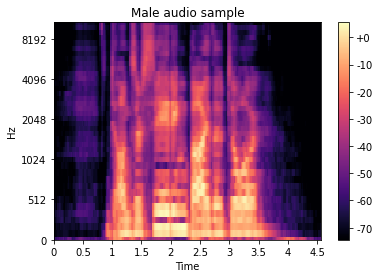

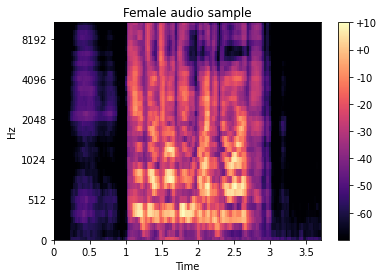

In [ ]:
hop_size= 512
#plotting for male and female samples
calculate_mel_spectogram(male_sound, hop_size,"Male audio sample")
calculate_mel_spectogram(female_sound, hop_size,"Female audio sample" )

# Observation:
We can spot few differences here too, let's shortlist this feature.

In [ ]:
#atlast let's extract MFCC coefficients too
def calculate_mfcc(waveform, n_mfcc, sr, Label=None,visualisation= False):
  #calculating the mfcc
  mfcc = librosa.feature.mfcc(y=waveform , n_mfcc=13, sr = sr)
  # calculating first,second and third order MFCC derivatives too
  first_derivative = librosa.feature.delta(mfcc, order=1)
  #second
  second_derivative = librosa.feature.delta(mfcc, order=2)
  #third
  third_derivative = librosa.feature.delta(mfcc, order=3)
  if visualisation== True:
    #plotting each mfcc
    librosa.display.specshow(mfcc,x_axis ="time", sr = 22050)
    plt.colorbar(format = "%2.f")
    plt.title(Label + "MFCC")
    plt.show()

    #plotting derivatives too
    #plotting each mfcc
    librosa.display.specshow(first_derivative,x_axis ="time", sr = 22050)
    plt.colorbar(format = "%2.f")
    plt.title(Label + "First Order MFCC")
    plt.show()
    
    #plotting each mfcc
    librosa.display.specshow(second_derivative,x_axis ="time", sr = 22050)
    plt.colorbar(format = "%2.f")
    plt.title(Label + "Second order MFCC")
    plt.show()
    
    #plotting each mfcc
    librosa.display.specshow(third_derivative,x_axis ="time", sr = 22050)
    plt.colorbar(format = "%2.f")
    plt.title(Label + "Third order MFCC")
    plt.show()
  elif visualisation == False:
    return mfcc


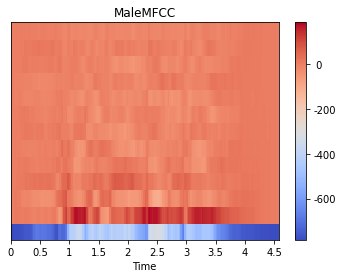

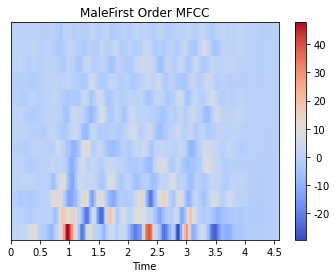

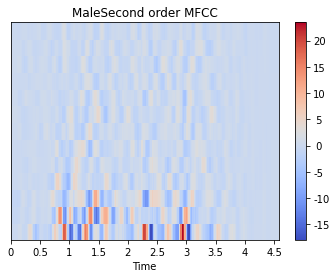

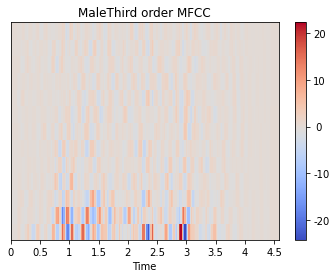

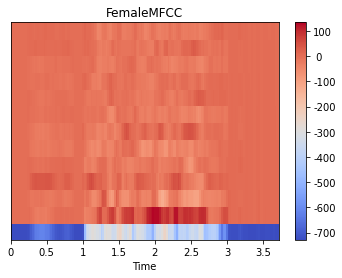

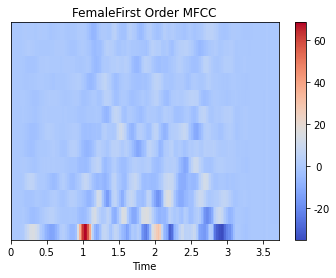

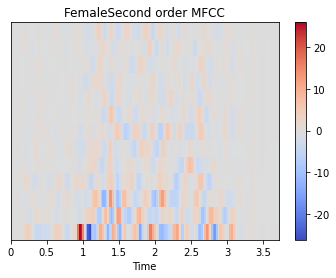

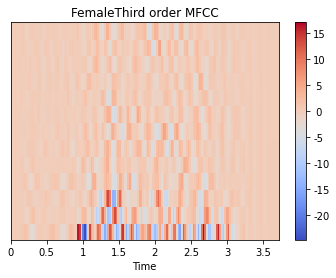

In [ ]:
# plotting mfcc for male and female samples
n_mfcc = 13
sr = 22050
calculate_mfcc(male_sound, n_mfcc, sr, "Male",visualisation= True)
calculate_mfcc(female_sound, n_mfcc, sr,"Female",visualisation= True)

Let's calculate pitch of the sound.

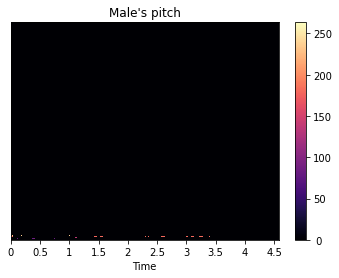

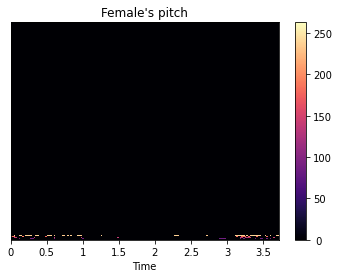

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [ ]:
# setting parameters
fmin = 65 #(< Lower bound of male)
fmax = 265 #(>Upper bound of female)
sr = 22050
#calculate the pitch
def calculate_pitch(waveform, fmin, fmax,sr, label=None,visualisation=False):
  pitches, magnitude = librosa.core.piptrack(y=waveform, sr =sr, fmin= fmin, fmax=fmax)
  if visualisation == True:
    librosa.display.specshow(pitches,x_axis ="time", sr = 22050)
    plt.colorbar(format = "%2.f")
    plt.title("{}'s pitch".format(label))
    plt.show()
  return pitches, magnitude

#plotting for male and female
calculate_pitch(male_sound,  fmin,fmax, sr, "Male", visualisation = True)
calculate_pitch(female_sound,  fmin,fmax, sr,"Female", visualisation = True)

In [ ]:
#let's calculate pitch using Spice model on Tf-Hub to visualise better.
model = hub.load("https://tfhub.dev/google/spice/2")

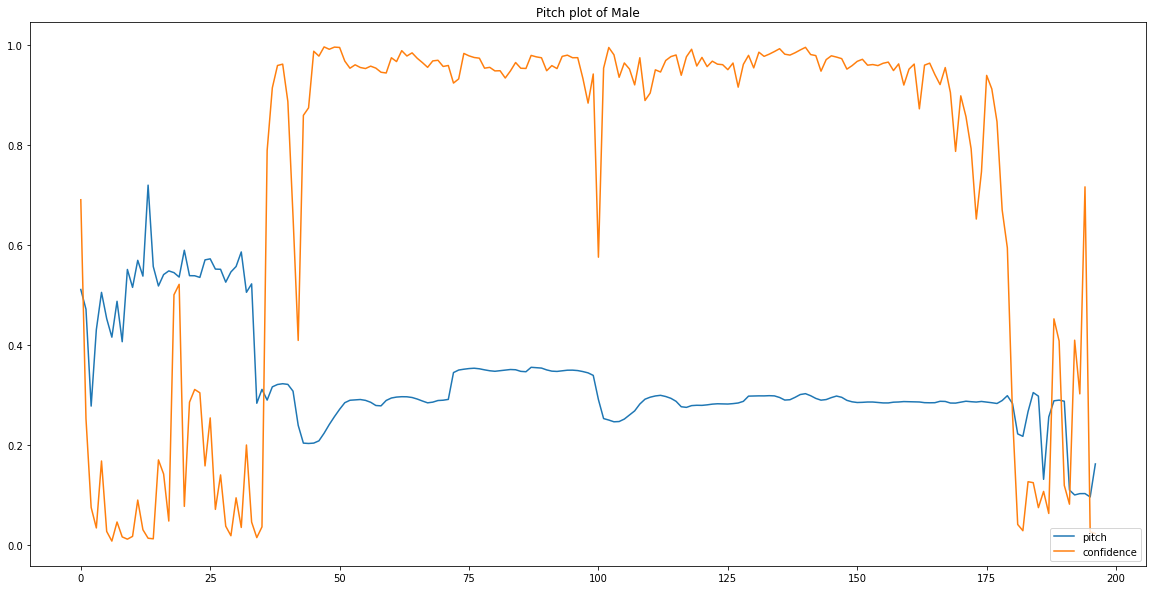

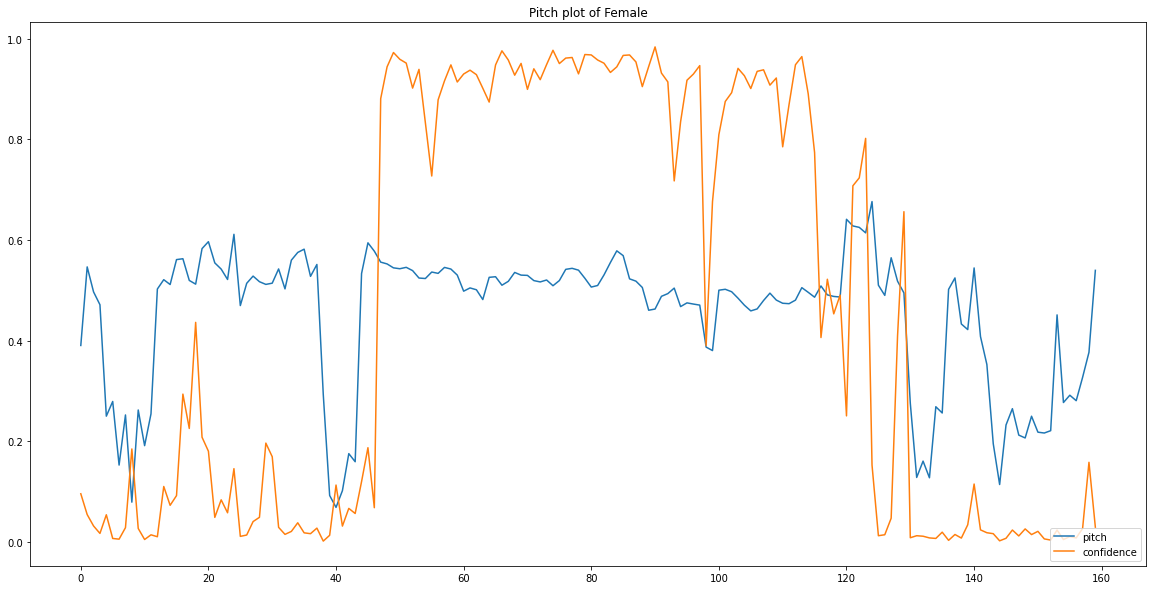

In [ ]:
#function
# src: https://www.tensorflow.org/hub/tutorials/spice
def calculate_pitch_unrefined(audio_sample,label=None,visualisation=False):
  # We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
  model_output = model.signatures["serving_default"](tf.constant(audio_sample, tf.float32))
  pitch_outputs = model_output["pitch"]
  uncertainty_outputs = model_output["uncertainty"]

  # 'Uncertainty' basically means the inverse of confidence.
  confidence_outputs = 1.0 - uncertainty_outputs
  if visualisation==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    plt.title('Pitch plot of {}'.format(label))
    plt.plot(pitch_outputs, label='pitch')
    plt.plot(confidence_outputs, label='confidence')
    plt.legend(loc="lower right")
    plt.show()
  elif visualisation == False:
    return pitch_output


#calculating for male and female sampels
calculate_pitch_unrefined(male_sound,"Male", visualisation= True)
calculate_pitch_unrefined(female_sound,"Female", visualisation= True)

# Observation:
Clearly, we can spot few notable differences between the pitches estimated by Spice model for Male and female sound.

Let's remove the low confidence pitch prediction.

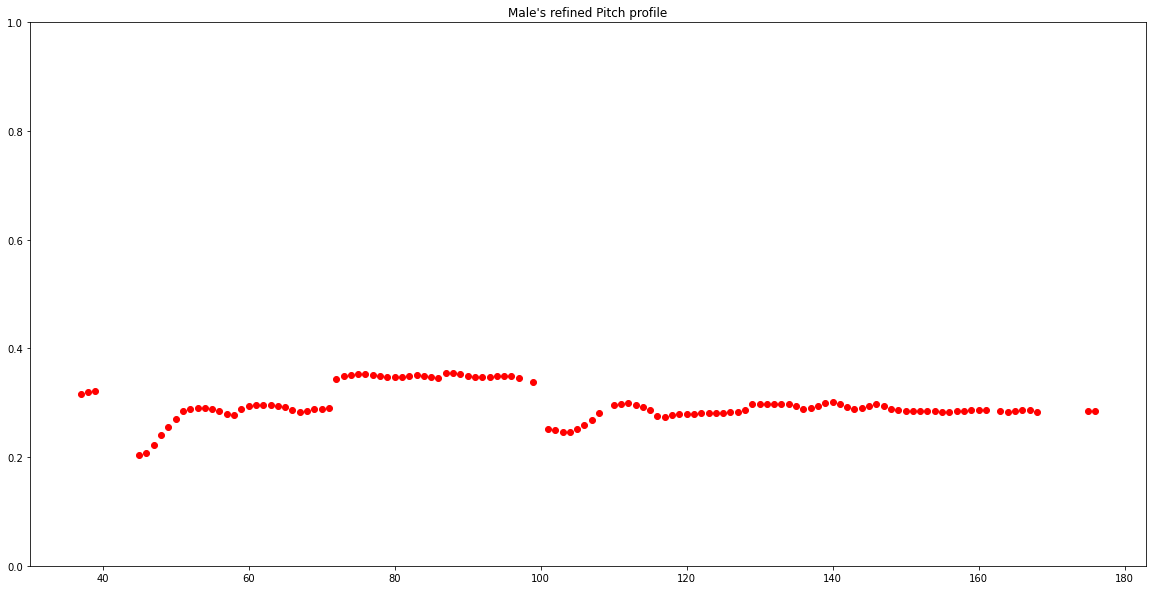

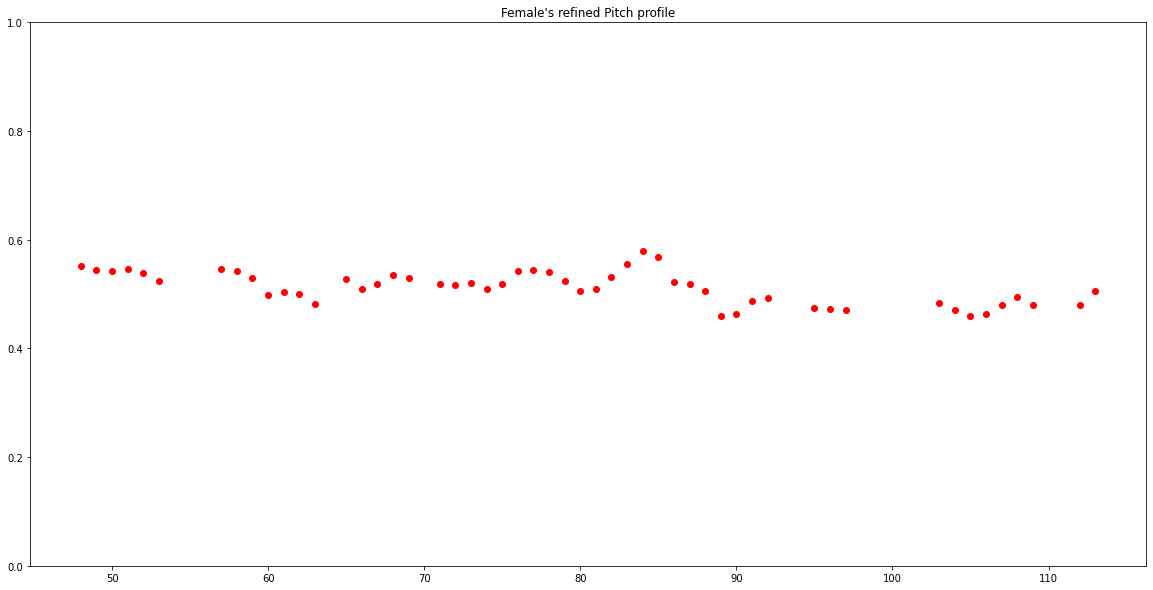

In [ ]:
def calculate_pitch_refined(audio_sample, label=None, visualisation= False):
  # We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
  model_output = model.signatures["serving_default"](tf.constant(audio_sample, tf.float32))
  pitch_outputs = model_output["pitch"]
  uncertainty_outputs = model_output["uncertainty"]

  
  # 'Uncertainty' basically means the inverse of confidence.
  confidence_outputs = 1.0 - uncertainty_outputs

  #keeping only the most confident pitch predictions
  confidence_outputs = list(confidence_outputs)
  pitch_outputs = [ float(x) for x in pitch_outputs]

  indices = range(len (pitch_outputs))
  confident_pitch_outputs = [ (i,p)  
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
  confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)


  if visualisation==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    ax.set_ylim([0, 1])
    plt.title("{}'s refined Pitch profile".format(label))
    #plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
    plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")
    plt.show()

  elif visualisation == False:
    return confident_pitch_outputs


#calculating for male and female sampels
calculate_pitch_refined(male_sound,"Male", visualisation= True)
calculate_pitch_refined(female_sound,"Female", visualisation= True)

# Observation:
Seems like we can use these features to classify the sound between male and female too. Now, let's collect shortlisted features from the above samples.

**Summary:**

We have shortlisted Log-frequency spectograms, MFCC and Pitch till now. 

# 2.C Feature Extraction Stage.
Let's extract the Spectogram, MFCC and pitch for each of our audio samples within the dataset using multiprocessing. We can use multi-threading too, since an I/o operation is involved.

You can follow this notebook for [Multiprocessing/Multithreading](https://colab.research.google.com/drive/1ncDlv-9AYolCa9ELR8bkE5_VNBM8Onj4?usp=sharing)

In [ ]:
dataset = gender_dataset.to_numpy()
Pitch = []
Labels = []
Mfcc = []
Spectograms = []
import tqdm

#helper function to load and process the audio waveform
def load_process(data):
  waveform_path = data[0]
  if data[1] == 'female':
    label = 1
  elif data[1] == "male":
    label = 0
  waveform,sr = librosa.load(waveform_path, mono=True)
  pitch = calculate_pitch_refined(waveform)
  #n-mel = 13
  mfcc = calculate_mfcc(waveform,13,sr)
  #frame_size = 2048 and  hop_size = 512
  spectogram = calculate_spectogram("log-frequency",female_sound,frame_size,512,return_output=True, visualize=False)
  return pitch,mfcc,spectogram, label
  

# using multi threading as it is an IO process
with concurrent.futures.ThreadPoolExecutor() as executor:
  process = executor.map(load_process, dataset)
  for result in process:
    Pitch.append(result[0])
    Mfcc.append(result[1])
    Spectograms.append(result[2])
    Labels.append(result[3])
    print("Processed")



Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed
Processed


In [ ]:
for mfcc in Mfcc:
  print(np.shape(mfcc))

(13, 220)
(13, 220)
(13, 213)
(13, 217)
(13, 187)
(13, 217)
(13, 199)
(13, 186)
(13, 199)
(13, 223)
(13, 156)
(13, 212)
(13, 182)
(13, 194)
(13, 206)
(13, 196)
(13, 209)
(13, 226)
(13, 193)
(13, 192)
(13, 193)
(13, 209)
(13, 197)
(13, 197)
(13, 196)
(13, 199)
(13, 196)
(13, 202)
(13, 189)
(13, 213)
(13, 183)
(13, 205)
(13, 223)
(13, 182)
(13, 205)
(13, 212)
(13, 203)
(13, 186)
(13, 192)
(13, 196)
(13, 228)
(13, 206)
(13, 215)
(13, 206)
(13, 200)
(13, 210)
(13, 246)
(13, 206)
(13, 203)
(13, 189)
(13, 192)
(13, 203)
(13, 197)
(13, 202)
(13, 173)
(13, 263)
(13, 219)
(13, 190)
(13, 217)
(13, 193)
(13, 166)
(13, 187)
(13, 190)
(13, 215)
(13, 180)
(13, 205)
(13, 151)
(13, 193)
(13, 182)
(13, 205)
(13, 189)
(13, 209)
(13, 225)
(13, 184)
(13, 216)
(13, 210)
(13, 196)
(13, 266)
(13, 190)
(13, 232)
(13, 242)
(13, 187)
(13, 193)
(13, 196)
(13, 213)
(13, 213)
(13, 232)
(13, 207)
(13, 186)
(13, 192)
(13, 202)
(13, 173)
(13, 209)
(13, 243)
(13, 200)
(13, 203)
(13, 180)
(13, 180)
(13, 199)
(13, 192)


In [ ]:
#since mfcc features are of different length so we will have to pad them with zeros at the end.
# we will use np.pad
# helper function
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')


# Quick check of the function
# A = [1,2,3,4,5,6]
# B = [1,2,3]
# C = [1,4,5,6,7,8,8,94,5,6]

# size = max(len(A), len(B), len(C))
# print(size)
# A = padarray(A, size)
# B = padarray(B, size)
# C = padarray(C, size)
# print(A)
# print(B)
# print(C)

In [ ]:
# Calculating the max size of MFCC array
size = []
for mfcc in Mfcc:
  size.append(np.shape(mfcc)[1])
#max value
max_size = max(size)
print(max_size)

zero_padded_mfcc = []
# now zero padding each mfcc to same size
for mfcc in Mfcc:
  array = []
  for idx in range(len(mfcc)):
     array.append(padarray(mfcc[idx],max(size)))
  zero_padded_mfcc.append(array)

275


In [ ]:
# Now converting MFCC list of ndarrays to array
print(np.shape(zero_padded_mfcc))
print(len(Mfcc))

(1012, 13, 275)
1012


In [ ]:
#similarly checking the shape of each ndarray in Pitch
for pitch in Pitch:
  print(np.shape(pitch))

(101, 2)
(121, 2)
(128, 2)
(108, 2)
(122, 2)
(146, 2)
(82, 2)
(103, 2)
(129, 2)
(111, 2)
(68, 2)
(109, 2)
(62, 2)
(85, 2)
(98, 2)
(83, 2)
(98, 2)
(121, 2)
(68, 2)
(66, 2)
(75, 2)
(69, 2)
(71, 2)
(81, 2)
(77, 2)
(138, 2)
(129, 2)
(123, 2)
(95, 2)
(112, 2)
(100, 2)
(100, 2)
(130, 2)
(65, 2)
(96, 2)
(112, 2)
(93, 2)
(99, 2)
(65, 2)
(76, 2)
(147, 2)
(126, 2)
(122, 2)
(99, 2)
(111, 2)
(88, 2)
(142, 2)
(108, 2)
(61, 2)
(61, 2)
(109, 2)
(111, 2)
(103, 2)
(132, 2)
(106, 2)
(178, 2)
(111, 2)
(88, 2)
(99, 2)
(50, 2)
(51, 2)
(104, 2)
(92, 2)
(105, 2)
(108, 2)
(101, 2)
(73, 2)
(77, 2)
(73, 2)
(96, 2)
(123, 2)
(114, 2)
(108, 2)
(95, 2)
(105, 2)
(96, 2)
(44, 2)
(177, 2)
(83, 2)
(119, 2)
(138, 2)
(107, 2)
(87, 2)
(94, 2)
(123, 2)
(135, 2)
(116, 2)
(95, 2)
(74, 2)
(92, 2)
(95, 2)
(61, 2)
(102, 2)
(136, 2)
(101, 2)
(69, 2)
(98, 2)
(54, 2)
(99, 2)
(85, 2)
(173, 2)
(110, 2)
(105, 2)
(121, 2)
(99, 2)
(92, 2)
(88, 2)
(139, 2)
(103, 2)
(83, 2)
(110, 2)
(111, 2)
(87, 2)
(161, 2)
(100, 2)
(108, 2)
(82, 2)
(95

In [ ]:
# Calculating the max size of MFCC array
def zero_pad_pitch(A, size):
  pad_length = size- len(A)
  B = list(np.zeros((pad_length,2)))
  return list(A)+list(B)  

In [ ]:

    
size = []
for pitch in Pitch:
  size.append(np.shape(pitch)[0])
#max value
max_size = max(size)
print(max_size)

zero_padded_pitch = []
# now zero padding each mfcc to same size
for pitch in Pitch:
  zero_padded_pitch.append(zero_pad_pitch(pitch,max_size))
  

195


In [ ]:
# Now converting MFCC list of ndarrays to array
print(np.shape(zero_padded_pitch))
print(len(Pitch))

(1012, 195, 2)
1012


In [ ]:
# saving each to numpy files
np.save('pitch.npy', zero_padded_pitch)
np.save('mfcc.npy', zero_padded_mfcc)
np.save('labels.npy', Labels)
np.save('spectograms.npy', Spectograms)

In [ ]:
#loading the saved arrays from numpy files
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/GenderDetectionUsingVoice')
Pitch = np.load('pitch.npy', allow_pickle=True)
zero_padded_mfcc = np.load('mfcc.npy', allow_pickle=True)
Labels = np.load('labels.npy', allow_pickle=True)
Spectograms = np.load('spectograms.npy', allow_pickle=True)

In [ ]:
#converting to numpy arrays
Pitch = np.asarray(Pitch)
mfcc = np.asarray(zero_padded_mfcc)
Labels = np.asarray(Labels)
Spectograms = np.asarray(Spectograms)
print(f'Shape of processed Pitch from dataset is {np.shape(Pitch)}')
print(f'Shape of processed MFCC from dataset is {np.shape(mfcc)}')
print(f'Shape of processed Labels from dataset is {np.shape(Labels)}')
print(f'Shape of processed Spectograms from dataset is {np.shape(Spectograms)}')

Shape of processed Pitch from dataset is (1012, 195, 2)
Shape of processed MFCC from dataset is (1012, 13, 275)
Shape of processed Labels from dataset is (1012,)
Shape of processed Spectograms from dataset is (1012, 1025, 160)


In [ ]:
# converting labels to one hot encoded vectors
label_encoder = LabelEncoder()
integer_encoded  = label_encoder.fit_transform(Labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_labels = onehot_encoder.fit_transform(integer_encoded)
print(np.shape(onehot_encoded_labels))

(1012, 2)


# Dataset Splitting 
Splitting the training dataset pairs into train and test split

i.e 
* Spectograms - Labels pairs
* Mfcc - Label pairs
* Pitch - Label pairs

In [ ]:
# train-test split for spectograms
X_train_spectograms, X_test_spectograms, y_train_spectograms, y_test_spectograms = train_test_split(Spectograms, Labels, random_state=42, test_size=0.3)
# train test split for MFCC
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(mfcc, Labels, random_state=42, test_size=0.3)
# train test split for Pitch
X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(Pitch, Labels, random_state=42, test_size=0.3)

# 3. Training Phase
We'll be training SVC Machine Learning algorithm on the extracted features and labels.




In [ ]:
#support vector machine
param_grid = {'C':(1, 10,100,1000), 'gamma':(0.1, 0.01,0.001,0.0001)}
#creating an object of support vector classifier
gender_classifier = SVC()

In [ ]:
#creating three instances of object
grid_search_spectograms = GridSearchCV(gender_classifier, param_grid, cv=5, verbose=10,n_jobs = 3)
grid_search_mfcc = GridSearchCV(gender_classifier, param_grid, cv=5, verbose=10,n_jobs = 3)
grid_search_pitch = GridSearchCV(gender_classifier, param_grid, cv=5, verbose=10,n_jobs = 3)

In [ ]:
#fitting on spectograms
# reshaping X_train 3D array to X_train 2D i.e num_samples, nx*ny
X_train_spectograms = X_train_spectograms.reshape(X_train_spectograms.shape[0],X_train_spectograms.shape[1]* X_train_spectograms.shape[2])
grid_search_spectograms.fit(X_train_spectograms,y_train_spectograms)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  3.3min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 13.2min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 23.0min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 29.6min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 39.5min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 49.5min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 62.6min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 73.1min
[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed: 88.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': (1, 10, 100, 1000),
                         'gamma': (0.1, 0.01, 0.001, 0.0001)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [ ]:
# printing out the best params
grid_search_spectograms.best_params_

{'C': 1, 'gamma': 0.1}

In [ ]:
#instantiating with best grid search params
gender_classifier_spectogram = SVC(C=1, gamma=0.1).fit(X_train_spectograms, y_train_spectograms)

In [ ]:
# reshaping X_train 3D array to X_train 2D i.e num_samples, nx*ny
X_test_spectograms = X_test_spectograms.reshape(X_test_spectograms.shape[0],X_test_spectograms.shape[1]* X_test_spectograms.shape[2])
gender_classifier_spectogram.score(X_test_spectograms, y_test_spectograms)

0.5394736842105263

In [ ]:
y_pred_spectograms = gender_classifier_spectogram.predict(X_test_spectograms)

In [ ]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test_spectograms, y_pred_spectograms))
print("*************************************************")
print("Classifiction Report :")
print(classification_report(y_test_spectograms, y_pred_spectograms))

Confusion Matrix: 
[[164   0]
 [140   0]]
*************************************************
Classifiction Report :
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       164
           1       0.00      0.00      0.00       140

    accuracy                           0.54       304
   macro avg       0.27      0.50      0.35       304
weighted avg       0.29      0.54      0.38       304



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#saving the trained model

with open('svm_spectogram.pkl', 'wb') as fid:
    pickle.dump(gender_classifier_spectogram, fid)    

# # load it again
# with open('svm_spectogram.pkl', 'rb') as fid:
#     model = pickle.load(fid)
  

In [ ]:
#similarly fitting on mfcc
#fitting on spectograms
# reshaping X_train 3D array to X_train 2D i.e num_samples, nx*ny
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0],X_train_mfcc.shape[1]* X_train_mfcc.shape[2])
grid_search_mfcc.fit(X_train_mfcc,y_train_mfcc)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   14.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   19.1s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   30.9s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   39.4s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   52.0s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': (1, 10, 100, 1000),
                         'gamma': (0.1, 0.01, 0.001, 0.0001)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [ ]:
# printing out the best params
grid_search_mfcc.best_params_

{'C': 1, 'gamma': 0.1}

In [ ]:
#instantiating with best grid search params
gender_classifier_mfcc = SVC(C=1, gamma=0.1).fit(X_train_mfcc, y_train_mfcc)

In [ ]:
# reshaping X_train 3D array to X_train 2D i.e num_samples, nx*ny
X_test_mfcc = X_test_mfcc.reshape(X_test_mfcc.shape[0],X_test_mfcc.shape[1]* X_test_mfcc.shape[2])
gender_classifier_mfcc.score(X_test_mfcc, y_test_mfcc)

0.5394736842105263

In [ ]:
y_pred_mfcc = gender_classifier_mfcc.predict(X_test_mfcc)


In [ ]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test_mfcc, y_pred_mfcc))
print("*************************************************")
print("Classifiction Report :")
print(classification_report(y_test_mfcc, y_pred_mfcc))

Confusion Matrix: 
[[164   0]
 [140   0]]
*************************************************
Classifiction Report :
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       164
           1       0.00      0.00      0.00       140

    accuracy                           0.54       304
   macro avg       0.27      0.50      0.35       304
weighted avg       0.29      0.54      0.38       304



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#saving the trained model

with open('svm_mfcc.pkl', 'wb') as fid:
    pickle.dump(gender_classifier_mfcc, fid)    

# # load it again
# with open('svm_spectogram.pkl', 'rb') as fid:
#     model = pickle.load(fid)
  

In [ ]:
# Now using pitch
# reshaping X_train 3D array to X_train 2D i.e num_samples, nx*ny
X_train_pitch = X_train_pitch.reshape(X_train_pitch.shape[0],X_train_pitch.shape[1]* X_train_pitch.shape[2])
grid_search_pitch.fit(X_train_pitch,y_train_pitch)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    5.7s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:    8.5s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:   12.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': (1, 10, 100, 1000),
                         'gamma': (0.1, 0.01, 0.001, 0.0001)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [ ]:
grid_search_pitch.best_params_

{'C': 100, 'gamma': 0.0001}

In [ ]:
#instantiating with best grid search params
gender_classifier_pitch = SVC(C=100, gamma=0.001).fit(X_train_pitch, y_train_pitch)

In [ ]:
# reshaping X_train 3D array to X_train 2D i.e num_samples, nx*ny
X_test_pitch = X_test_pitch.reshape(X_test_pitch.shape[0],X_test_pitch.shape[1]* X_test_pitch.shape[2])
gender_classifier_pitch.score(X_test_pitch, y_test_pitch)

0.6973684210526315

In [ ]:
y_pred_pitch = gender_classifier_pitch.predict(X_test_pitch)

In [ ]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test_pitch, y_pred_pitch))
print("*************************************************")
print("Classifiction Report :")
print(classification_report(y_test_pitch, y_pred_pitch))

Confusion Matrix: 
[[128  36]
 [ 56  84]]
*************************************************
Classifiction Report :
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       164
           1       0.70      0.60      0.65       140

    accuracy                           0.70       304
   macro avg       0.70      0.69      0.69       304
weighted avg       0.70      0.70      0.69       304



In [ ]:
#saving the trained model

with open('svm_pitch.pkl', 'wb') as fid:
    pickle.dump(gender_classifier_pitch, fid)    

# # load it again
# with open('svm_pitch.pkl', 'rb') as fid:
#     model = pickle.load(fid)
  

# Observations
Clearly the model fitted on Pitch values outperformed the ones fitted onto MFCC and Spectogram values. 

Let's inference the model on few samples from the internet now on these trained model to fetch the final remarks.



# 4. Inference Stage

We'll fetch 4 samples(2 Male and 2 Female) from [Link](https://www.telephonetics.com/index.php/samples/audio-samples) to evaluate our fitted SVC on MFCC, Spectograms and Pitch data. The files will be named as test(i).mp3 where i : 1 to 4

We'll take 4 random samples from gender_dataset_path dataframe too for evaluating the models.

For now, we have saved it in our GDrive by downloading.

In [ ]:
#loading the trained models
with open('svm_pitch.pkl', 'rb') as fid:
    pitch_model = pickle.load(fid)
with open('svm_mfcc.pkl', 'rb') as fid:
    mfcc_model = pickle.load(fid)
with open('svm_spectogram.pkl', 'rb') as fid:
    spectograms_model = pickle.load(fid)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#inference helper function
def predict(file , classifier_type):
  waveform, sr = librosa.load(file, mono=True)
  #extracting features i.e MFCC, Spectograms and pitch
  pitch = calculate_pitch_refined(waveform)
  #n-mel = 13
  mfcc = calculate_mfcc(waveform,13,sr)
  #frame_size = 2048 and  hop_size = 512
  spectogram = calculate_spectogram("log-frequency",female_sound,frame_size,512,return_output=True, visualize=False)

  if classifier_type == "MFCC":
    # zero pad the sequence at the end as per the shape used in training
    if np.shape(mfcc)[1]<= 275:
      #then pad
      array = []
      for idx in range(len(mfcc)):
          array.append(padarray(mfcc[idx],275))
      mfcc = np.asarray(array)
    elif np.shape(mfcc)[1]> 275:
      #trim to 13,275 as it is training feature vector sample size
      mfcc = mfcc[:,:275]
    mfcc= mfcc.reshape(1,-1)
    label = mfcc_model.predict(mfcc)
    if label == [0]:
      print(f"{file}'s prediction via {classifier_type} is Male")
    elif label == [1]:
      print(f"{file}'s prediction via {classifier_type} is Female")

  elif classifier_type == "Spectogram":
    #no zero padding required
    #reshaping the spectogram
    spectogram= spectogram.reshape(1,-1)
    label = spectograms_model.predict(spectogram)
    if label == [0]:
      print(f"{file}'s prediction via {classifier_type} is Male")
    elif label == [1]:
      print(f"{file}'s prediction via {classifier_type} is Female")
    
  elif classifier_type == "Pitch":
    # zero pad the sequence at the end as per the shape used in training
    if np.shape(pitch)[0]<= 195:
      #then pad
      pitch = zero_pad_pitch(pitch, 195)
      pitch = np.asarray(pitch)
    elif np.shape(pitch)[0]> 195:
      #trim to the size of training feature vector sample size i.e 195,2
      pitch = np.asarray(pitch)
      pitch = pitch[:195,:]
    pitch= pitch.reshape(1,-1)
    label = pitch_model.predict(pitch)
    if label == [0]:
      print(f"{file}'s prediction via {classifier_type} is Male")
    elif label == [1]:
      print(f"{file}'s prediction via {classifier_type} is Female")

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/GenderDetectionUsingVoice/TestSamples')

print("Predictions on Unseen samples")
#Predicting on test samples
for test_file in glob.glob('*.mp3'):
  print("*****************************************************")
  predict(test_file , "Pitch")
  print("*****************************************************")
  predict(test_file , "MFCC")
  print("*****************************************************")
  predict(test_file , "Spectogram")


Predictions on Unseen samples
*****************************************************
test1.mp3's prediction via Pitch is Male
*****************************************************
test1.mp3's prediction via MFCC is Male
*****************************************************
test1.mp3's prediction via Spectogram is Male
*****************************************************
test2.mp3's prediction via Pitch is Male
*****************************************************
test2.mp3's prediction via MFCC is Male
*****************************************************
test2.mp3's prediction via Spectogram is Male
*****************************************************
test3.mp3's prediction via Pitch is Male
*****************************************************
test3.mp3's prediction via MFCC is Male
*****************************************************
test3.mp3's prediction via Spectogram is Male
*****************************************************
test4.mp3's prediction via Pitch is Male
********

In [ ]:
print()
print("Predictions on Dataset samples")
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/GenderDetectionUsingVoice')
#Predicting on dataset samples
for i in range(4):
  idx = random.randint(1,len(gender_dataset))
  file_path = gender_dataset['path'][idx]
  ground_truth = gender_dataset['gender'][idx]
  print("*****************************************************")
  predict(file_path , "Pitch")
  print(f"Ground truth is {ground_truth}")
  print("*****************************************************")
  predict(file_path , "MFCC")
  print(f"Ground truth is {ground_truth}")
  print("*****************************************************")
  predict(file_path , "Spectogram")
  print(f"Ground truth is {ground_truth}")


Predictions on Dataset samples
*****************************************************
Actor_24/03-02-02-01-02-01-24.wav's prediction via Pitch is Female
Ground truth is female
*****************************************************
Actor_24/03-02-02-01-02-01-24.wav's prediction via MFCC is Female
Ground truth is female
*****************************************************
Actor_24/03-02-02-01-02-01-24.wav's prediction via Spectogram is Male
Ground truth is female
*****************************************************
Actor_10/03-02-04-02-02-02-10.wav's prediction via Pitch is Female
Ground truth is female
*****************************************************
Actor_10/03-02-04-02-02-02-10.wav's prediction via MFCC is Female
Ground truth is female
*****************************************************
Actor_10/03-02-04-02-02-02-10.wav's prediction via Spectogram is Male
Ground truth is female
*****************************************************
Actor_03/03-02-05-01-01-01-03.wav's prediction